In [35]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE

from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [36]:
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained('hustvl/yolos-tiny')

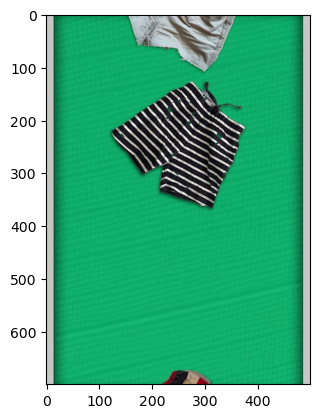

In [66]:
relative_path = get_training_data_path('production', 'band')
fullpath = os.path.join(relative_path, 'frame_205_.jpg')
image = Image.open(fullpath)

image = np.array(image)


plt.imshow(image)

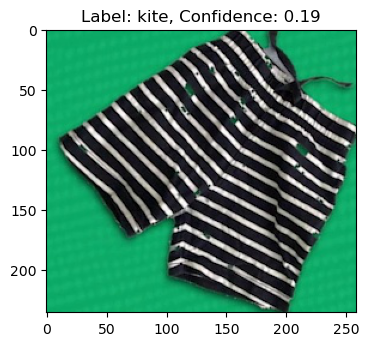

In [69]:
def process(image):
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes

    image_np = np.array(image)  # Convert the image to a NumPy array once
    height, width, _ = image_np.shape
    target_sizes = torch.tensor([[height, width]])  # Note the double square brackets

    results = image_processor.post_process_object_detection(outputs, threshold=0.16, target_sizes=target_sizes)[0]
    # Iterate over detected objects and process bounding boxes
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = box.detach().numpy()  # Detach tensor and convert to numpy array
        x_min, y_min, x_max, y_max = map(int, box)
        # Ensure bounding box is within image dimensions
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(width, x_max)
        y_max = min(height, y_max)



        cropped_image = image_np[y_min:y_max, x_min:x_max]
        x, y = cropped_image.shape[:2]
        if 100 <= y_min <= 200 and (x * y >= 60000):
            # Display the cropped image
            fig, ax_cropped = plt.subplots(1, figsize=(4, 4))  # Use reasonable size for the cropped image
            ax_cropped.imshow(cropped_image)
            ax_cropped.set_title(f'Label: {model.config.id2label[label.item()]}, Confidence: {score.item():0.2f}')
            plt.show()


# Replace `image` with your actual image variable
process(image)
